In [20]:
%matplotlib inline

In [9]:
import pybedtools
import scipy

import matplotlib.patches as mpatches
import pandas as pd
import numpy as np # need for  stats

from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

In [87]:
# load modules
import os
import glob
import pprint
from pybedtools import BedTool
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu

In [3]:
#First we need to define the base dirs
DIRS = {}
DIRS['BASE2'] = '/home/anjuni/analysis'
DIRS['FEATURES'] = os.path.join(DIRS['BASE2'], 'coverage', 'feature_files')
DIRS['RAND'] = os.path.join(DIRS['BASE2'], 'coverage', 'randomisation')
DIRS['WINDOW_OUTPUT'] = os.path.join(DIRS['BASE2'], 'windows')
DIRS['WINDOW_INPUT'] = os.path.join(DIRS['BASE2'], 'input_for_windows')
DIRS['REF'] = '/home/anjuni/Pst_104_v13_assembly/'
DIRS['COVERAGE'] = os.path.join(DIRS['BASE2'], 'coverage')

In [4]:

DIRS['TE_SF'] = os.path.join(DIRS['COVERAGE'], 'superfamily_files')
DIRS['RNA'] = os.path.join(DIRS['BASE2'], 'rna_counts')
DIRS['edgeR'] = os.path.join(DIRS['RNA'], 'edgeR_output')
DIRS['TRIALS'] = os.path.join(DIRS['RNA'], 'trials_tsv')
DIRS['MEAN_STD'] = os.path.join(DIRS['RNA'], 'average_and_stdev')
DIRS['GENE'] = os.path.join(DIRS['COVERAGE'], 'gene_level')
DIRS['GENE_ANNO'] = os.path.join(DIRS['GENE'], 'gene_anno')
DIRS['BOTH_U_D'] = os.path.join(DIRS['GENE'], 'both_upstream_downstream')
DIRS['DOWN_STR'] = os.path.join(DIRS['GENE'], 'downstream')
DIRS['UP_STR'] = os.path.join(DIRS['GENE'], 'upstream')
DIRS['TSS'] = os.path.join(DIRS['GENE'], 'tss_6mA_only')

In [5]:
DIRS['BASE1'] = '/home/anjuni/methylation_calling/pacbio'

DIRS['BED_INPUT'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'sequencing_comparison')
DIRS['GFF_INPUT'] = os.path.join(DIRS['BASE2'], 'gff_output')
DIRS['FIGURES'] = os.path.join(DIRS['BASE2'], 'figures')

DIRS['I_FROM_C'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'intersects_from_cutoffs')
DIRS['BED_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs')
DIRS['6MA_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_6mA')
DIRS['5MC_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_5mC')

### From here on some code to illustrate some of the analysis

In [126]:
h_contig_df = pd.read_csv(os.path.join(DIRS['FIGURES'], 'expression', 'rnaseq_methyl_df.tsv'),sep='\t' )

## This problem of the h_contig_df is that the 'gene_id' column is a bit of a mess if you fix this I can look at the BUSCO, effector part one more time.

In [161]:
gff_h_anno_TE_df = pd.read_csv('/home/anjuni/analysis/annotations/Pst_104E_v13_h_ctg.repeatgenesLT.gff3', header=None, sep='\t')
gff_h_anno_df = pd.read_csv('/home/anjuni/analysis/annotations/Pst_104E_v13_h_ctg.anno.gff3', header=None, sep='\t')

name_pattern = re.compile(r'Name=([^;]*)')
id_pattern = re.compile(r'ID=([^;]*)')

Name_id_dict = {}
for key in gff_h_anno_df[gff_h_anno_df[2] == 'gene'][8]:
    Name_id_dict[re.findall(name_pattern, key)[0]] = re.findall(id_pattern, key)[0]
for key in gff_h_anno_TE_df[gff_h_anno_TE_df[2] == 'gene'][8]:
    Name_id_dict[re.findall(name_pattern, key)[0]] = re.findall(id_pattern, key)[0]

In [162]:
h_contig_df['Protein_ID'] = h_contig_df['gene_ID'].apply(lambda x: Name_id_dict[x])

#### Now look at the GS expression of the most methylated genes (e.g. top 500) vs all

In [57]:
###This is the index of all highly methylated genes
h_contig_df.sort_values(by='5mC_gene_body_50', ascending=False).loc[:500].index

Int64Index([12305, 16500,  1688,  4107, 12007,  2631, 14515, 14767,  2215,
             5824,
            ...
            15096, 13614, 13615,  7163, 13616,   506,   505,   501,  4520,
              500],
           dtype='int64', length=16988)

In [137]:
#get a true false column for plotting and analysis
h_contig_df["Top_500_5mC_gene_body_50"] = "False"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_gene_body_50', ascending=False).loc[:500].index,"Top_500_5mC_gene_body_50"] = "True"

#add 0.1 for log transformation
h_contig_df['UG_01'] = h_contig_df['UG'] + 0.1


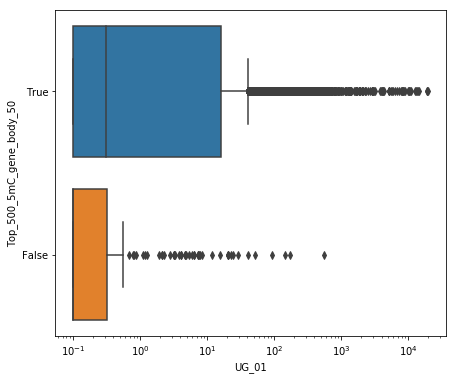

In [139]:
#quick plot for comparing expression of highly methylated genes versus the rest
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='UG_01', y="Top_500_5mC_gene_body_50", data=h_contig_df)

In [140]:
#do some quick stats if those are different from each other
mannwhitneyu(h_contig_df[h_contig_df["Top_500_5mC_gene_body_50"] == 'False']['UG_01'],h_contig_df[h_contig_df["Top_500_5mC_gene_body_50"] == 'True']['UG_01'] )

MannwhitneyuResult(statistic=1208273.5, pvalue=3.5252246099440555e-17)

In [84]:
h_contig_df.columns

Index(['gene_ID', 'GS', 'HE', 'IT0', 'IT6', 'IT9', 'UG', '5mC_gene_body_50',
       '6mA_gene_body_50', '5mC_upstream_50', '6mA_upstream_50',
       '5mC_upstream_50.1', '6mA_upstream_50.1', '5mC_downstream_50',
       '6mA_downstream_50', '5mC_gene_body_95', '6mA_gene_body_95',
       '5mC_upstream_95', '6mA_upstream_95', '5mC_downstream_95',
       '6mA_downstream_95', 'Top_500_5mC_gene_body_50', 'GS_01',
       'Top_500_6mA_gene_body_500', 'Top_500_6mA_gene_body_95'],
      dtype='object')

### now the same for another 6m methylation

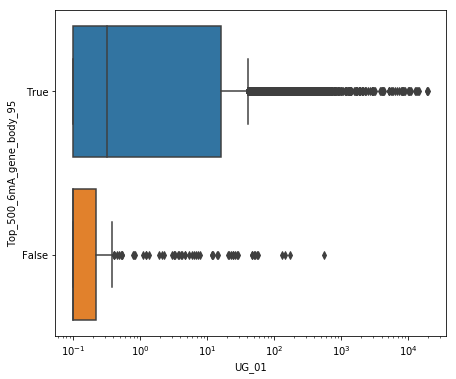

In [141]:
#get a true false column for plotting and analysis
h_contig_df["Top_500_6mA_gene_body_95"] = "False"
h_contig_df.loc[h_contig_df.sort_values(by='6mA_gene_body_50', ascending=False).loc[:500].index,"Top_500_6mA_gene_body_95"] = "True"
#quick plot for comparing expression of highly methylated genes versus the rest
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='UG_01', y="Top_500_6mA_gene_body_95", data=h_contig_df)

### Now with the strickter cut offs

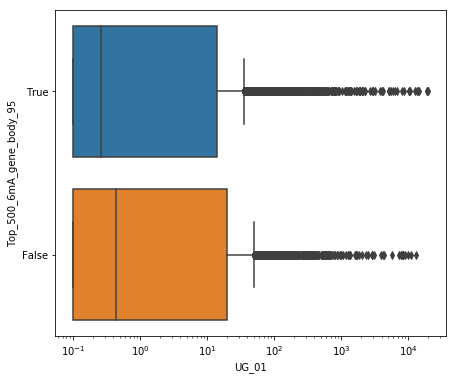

In [142]:
#get a true false column for plotting and analysis
h_contig_df["Top_500_6mA_gene_body_95"] = "False"
h_contig_df.loc[h_contig_df.sort_values(by='6mA_gene_body_95', ascending=False).loc[:500].index,"Top_500_6mA_gene_body_95"] = "True"
#quick plot for comparing expression of highly methylated genes versus the rest
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='UG_01', y="Top_500_6mA_gene_body_95", data=h_contig_df)

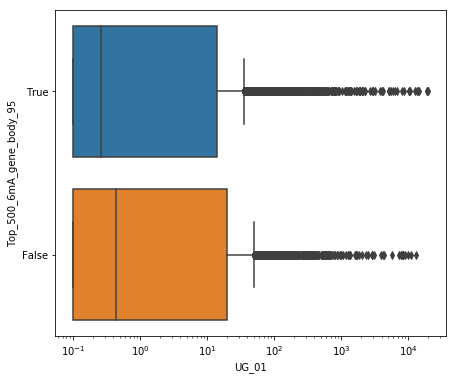

In [143]:
#get a true false column for plotting and analysis
h_contig_df["Top_500_6mA_gene_body_95"] = "False"
h_contig_df.loc[h_contig_df.sort_values(by='6mA_gene_body_95', ascending=False).loc[:500].index,"Top_500_6mA_gene_body_95"] = "True"
#quick plot for comparing expression of highly methylated genes versus the rest
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='UG_01', y="Top_500_6mA_gene_body_95", data=h_contig_df)

## Now on to looking getting BUSCOS and EFFECTORs into the game

In [167]:
GENE_BED_FOLDER = '/home/anjuni/beds/'
busco_gene_bed = 'Pst_104E_v12_h_busco.gene.bed'
effector_gene_bed = 'Pst_104E_v12_h_effector.gene.bed'
#s.listdir(GENE_BED_FOLDER)

In [174]:
BUSCO_list = pd.read_csv(os.path.join(GENE_BED_FOLDER, busco_gene_bed), sep='\t', header=None)[3].tolist()
effctor_list = pd.read_csv(os.path.join(GENE_BED_FOLDER, effector_gene_bed), sep='\t', header=None)[3].tolist()

In [165]:
#Please fix gene_ID you have two issuse at once
#EVM prediction%2, which is easy to fix
#and 0000_003.5 vs. 0000_03.3. With different amounts of '0' if you fix this during the creation I can show you the rest of the BUSCO and effector part
h_contig_df['BUSCO'] = 'False'
h_contig_df.loc[h_contig_df.Protein_ID.isin(BUSCO_list), 'BUSCO'] = 'True'

### BUSCO 5mC gene body methylation

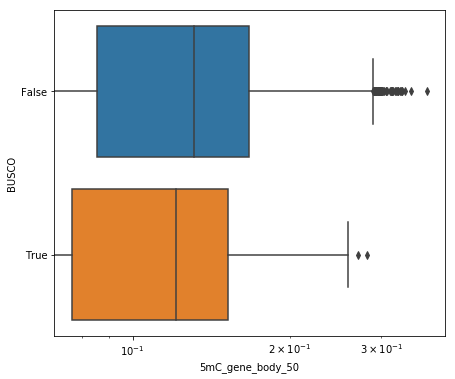

In [166]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='5mC_gene_body_50', y="BUSCO", data=h_contig_df)

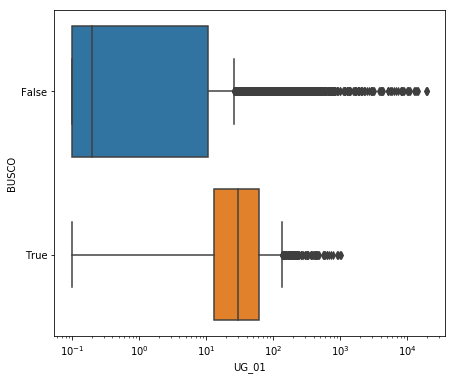

In [176]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='UG_01', y="BUSCO", data=h_contig_df)

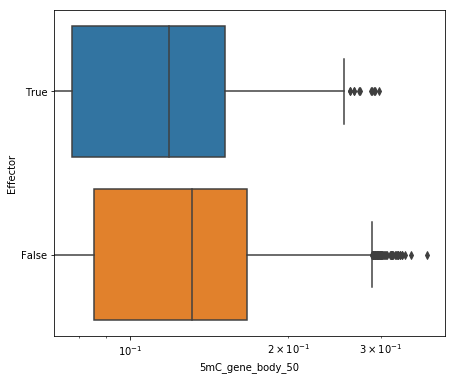

In [177]:
#Please fix gene_ID you have two issuse at once
h_contig_df.loc[h_contig_df.Protein_ID.isin(effctor_list), 'Effector'] = 'True'
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='5mC_gene_body_50', y="Effector", data=h_contig_df)

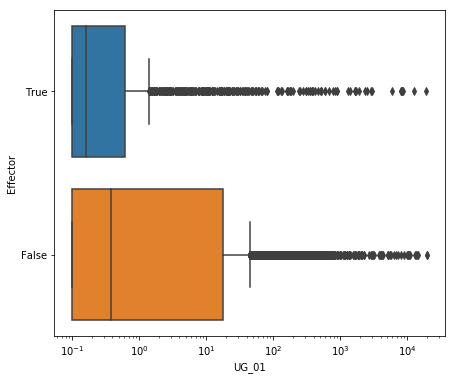

In [175]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='UG_01', y="Effector", data=h_contig_df)

In [178]:
###or by gene type
h_contig_df['Gene_type'] = 'All genes'
h_contig_df.loc[h_contig_df.Protein_ID.isin(effctor_list), 'Gene_type'] = 'Effector'
h_contig_df.loc[h_contig_df.Protein_ID.isin(BUSCO_list), 'Gene_type'] = 'BUSCO'

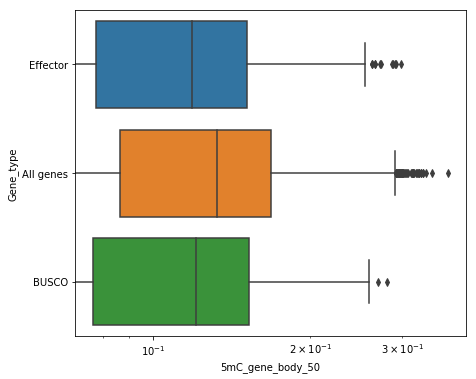

In [179]:
h_contig_df.loc[h_contig_df.Protein_ID.isin(effctor_list), 'Effector'] = 'True'
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='5mC_gene_body_50', y='Gene_type', data=h_contig_df)

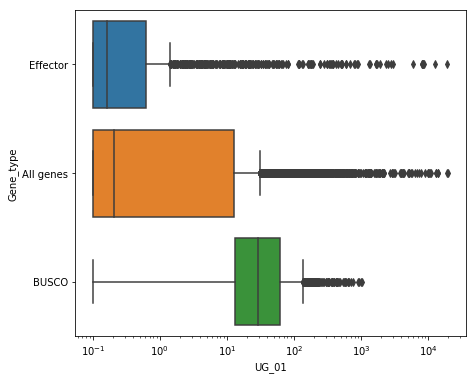

In [180]:
h_contig_df.loc[h_contig_df.Protein_ID.isin(effctor_list), 'Effector'] = 'True'
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='UG_01', y='Gene_type', data=h_contig_df)

In [182]:
h_contig_df.columns

Index(['gene_ID', 'GS', 'HE', 'IT0', 'IT6', 'IT9', 'UG', '5mC_gene_body_50',
       '6mA_gene_body_50', '5mC_upstream_50', '6mA_upstream_50',
       '5mC_upstream_50.1', '6mA_upstream_50.1', '5mC_downstream_50',
       '6mA_downstream_50', '5mC_gene_body_95', '6mA_gene_body_95',
       '5mC_upstream_95', '6mA_upstream_95', '5mC_downstream_95',
       '6mA_downstream_95', 'Top_500_5mC_gene_body_50', 'UG_01',
       'Top_500_6mA_gene_body_95', 'Protein_ID', 'BUSCO', 'Effector',
       'Gene_type'],
      dtype='object')

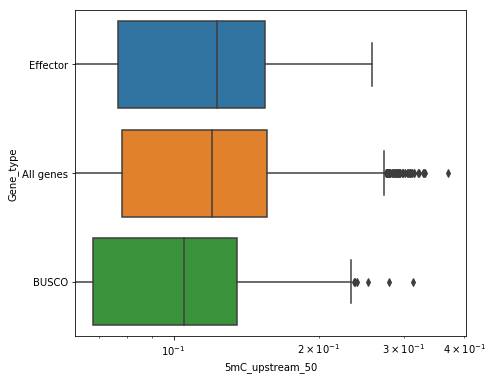

In [183]:
h_contig_df.loc[h_contig_df.Protein_ID.isin(effctor_list), 'Effector'] = 'True'
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='5mC_upstream_50', y='Gene_type', data=h_contig_df)

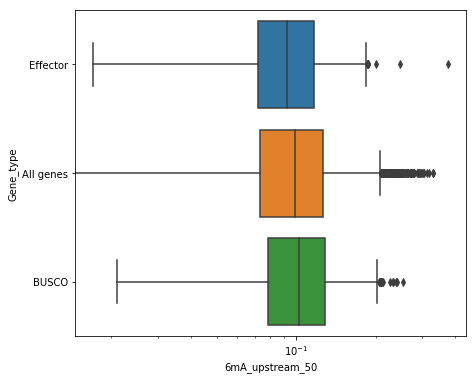

In [184]:
h_contig_df.loc[h_contig_df.Protein_ID.isin(effctor_list), 'Effector'] = 'True'
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='6mA_upstream_50', y='Gene_type', data=h_contig_df)

5mC_gene_body_50
6mA_gene_body_50
5mC_upstream_50
6mA_upstream_50
5mC_upstream_50.1
6mA_upstream_50.1
5mC_downstream_50
6mA_downstream_50
5mC_gene_body_95
6mA_gene_body_95


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/ticker.py:2041: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


5mC_upstream_95
6mA_upstream_95
5mC_downstream_95
6mA_downstream_95


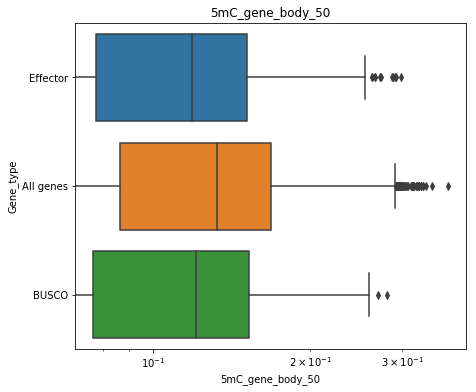

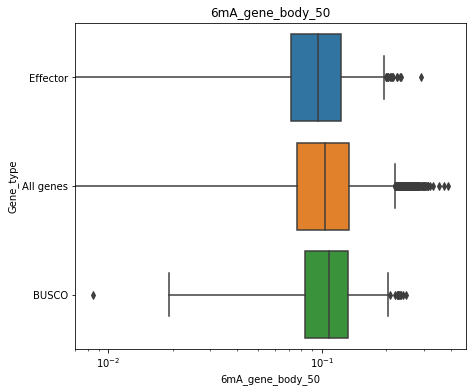

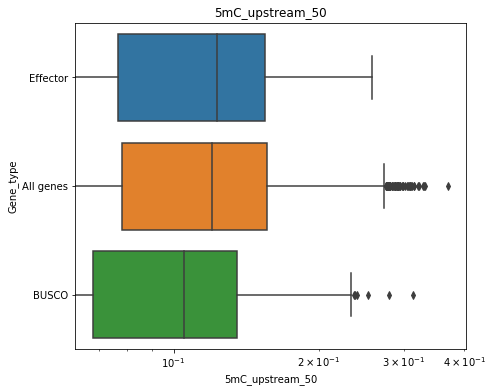

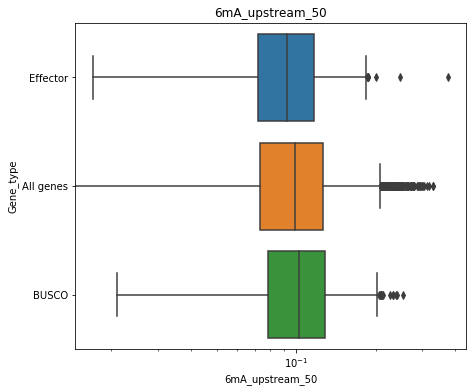

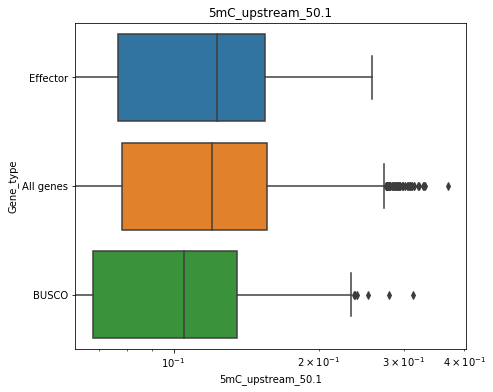

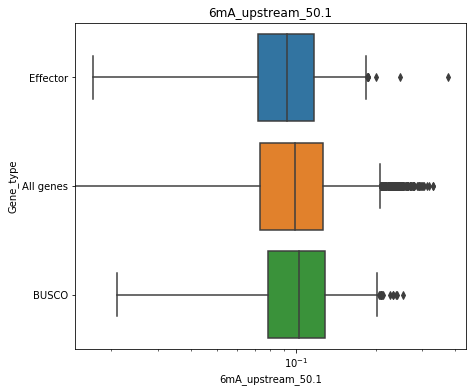

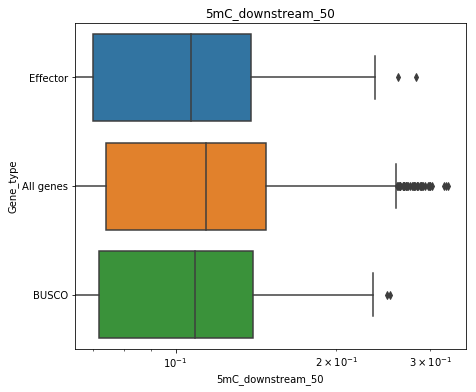

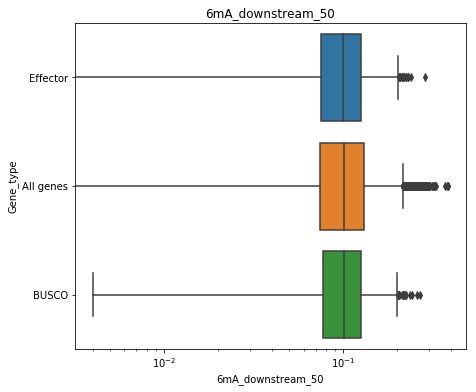

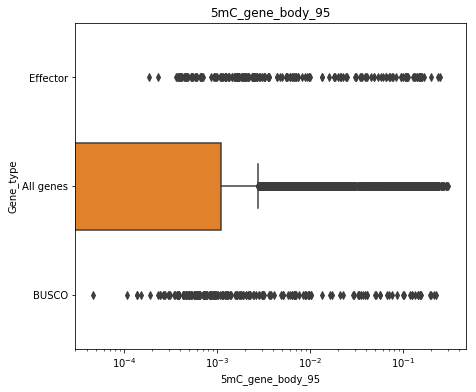

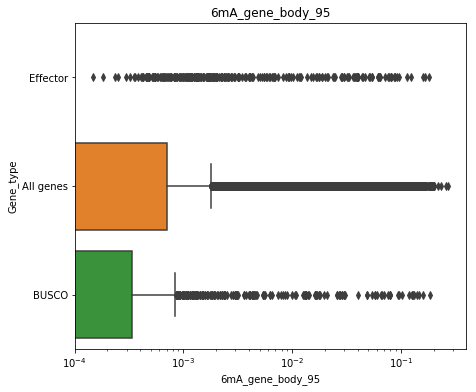

In [ ]:
for x in ['5mC_gene_body_50',
       '6mA_gene_body_50', '5mC_upstream_50', '6mA_upstream_50',
       '5mC_upstream_50.1', '6mA_upstream_50.1', '5mC_downstream_50',
       '6mA_downstream_50', '5mC_gene_body_95', '6mA_gene_body_95',
       '5mC_upstream_95', '6mA_upstream_95', '5mC_downstream_95',
       '6mA_downstream_95']:
    print(x)
    f, ax = plt.subplots(figsize=(7, 6))
    ax.set_xscale("log")
    sns.boxplot(x=x, y='Gene_type', data=h_contig_df)
    plt.title(x)